In [1]:
import os
import math
import pandas as pd
import numpy as np
import umap

# Configuration settings
from chasm.config import CONFIG

# PLINK preprocessing utilities
from chasm.plink_preprocessing import (
    test, 
    concat_AFs, 
    divide_into_chunks, 
    make_ids,
    make_AFs
)

from chasm.data_preprocessing import (
    is_snp,
    make_df,
    calculate_AFs,
    merge_AFs_ensembl_build,
    divide_into_chunks,
    align_dataframes,
)
from chasm.gwas import ols_regression, pca_of_n_snps, project_on_dimensions

from chasm.visualization import make_population_plot
from chasm.ld_blocks import segmenter
from chasm.abyss import linear_abyss

from chasm.fst import make_fst, make_global_fst
from chasm.cluster import silhouette_score_clusters

2025-02-13 17:16:18.134885: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-13 17:16:18.137179: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-13 17:16:18.177880: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-13 17:16:18.179039: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-02-13 17:16:19.118090: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not fin

In [3]:
# Changing the GTM data into a pickle file having an id file and calculating the AFs for each SNP 
# with the CHROM:POS for every corresponding RSID
"""
# GTM data
path_data_raw = f"{CONFIG['PATH_data']}/00_raw/recoded_1000G.raw"
path_raw = f"{CONFIG['PATH_data']}/01_raw/"
path_usefull = f"{CONFIG['PATH_data']}/02_usefull/"

geno = make_df(path_data_raw, path_usefull, path_raw)

afs = calculate_AFs(geno)

path_ensembl = f"/mnt/e/1000G_data/usefull/ensembl_build"
merge_AFs_ensembl_build(path_ensembl, path_usefull, afs)
"""
# Divide the AFs into chunks
"""
size_chunck = 20_000
min_maf = 0.01

path_raw = f"{CONFIG['PATH_data']}/01_raw/geno.pkl"
path_afs = f"{CONFIG['PATH_data']}/02_usefull/allele_frequencies.pkl"
path_output = f"{CONFIG['PATH_data']}/03_macro_similar_AF/"

divide_into_chunks(path_raw, path_afs, path_output, size_chunck, min_maf)
"""

'\nsize_chunck = 20_000\nmin_maf = 0.01\n\npath_raw = f"{CONFIG[\'PATH_data\']}/01_raw/geno.pkl"\npath_afs = f"{CONFIG[\'PATH_data\']}/02_usefull/allele_frequencies.pkl"\npath_output = f"{CONFIG[\'PATH_data\']}/03_macro_similar_AF/"\n\ndivide_into_chunks(path_raw, path_afs, path_output, size_chunck, min_maf)\n'

# Choose SNPs to project on n dimensions

In [6]:
"""
path_input = f"{CONFIG['PATH_data']}/03_macro_similar_AF/"
path_output = f"{CONFIG['PATH_data']}/04_projected/"
nr_of_projected_dimensions = 3
project_on_dimensions(path_input, path_output, nr_of_projected_dimensions)
"""

'\npath_input = f"{CONFIG[\'PATH_data\']}/03_macro_similar_AF/"\npath_output = f"{CONFIG[\'PATH_data\']}/04_projected/"\nnr_of_projected_dimensions = 3\nproject_on_dimensions(path_input, path_output, nr_of_projected_dimensions)\n'

# Observe raw dimensions

In [7]:
path_input = f"{CONFIG['PATH_data']}/04_projected/snp_ids.pkl"
pd.read_pickle(path_input)

,pval,betas,snp_rs,-logp,dim
139,7.102686e-82,-10.517221,rs10803434_A,81.148577,1
689,1.166225e-79,-10.416983,rs11802371_G,78.933218,1
18,1.411884e-67,9.669418,rs12743883_G,66.850201,1
0,2.621310e-65,9.577107,rs3928804_T,64.581482,1
321,2.964500e-65,-9.474779,rs4424509_G,64.528048,1
...,...,...,...,...,...
105,8.556152e-01,0.060693,rs1009059_C,0.067722,3
7,8.609565e-01,-0.050215,rs1894252_A,0.065019,3
75,8.965162e-01,0.037620,rs135972_G,0.047442,3
101,9.850593e-01,0.005892,rs1974458_G,0.006538,3


In [4]:
path_input = f"{CONFIG['PATH_data']}/04_projected/"
path_afs = f"{CONFIG['PATH_data']}/02_usefull/allele_frequencies.pkl"
path_ids = f"{CONFIG['PATH_data']}/02_usefull/ids.pkl"
path_panel = f"{CONFIG['PATH_data']}/02_usefull/all.panel"
ids = pd.read_pickle(path_ids)
labels = pd.read_pickle(path_panel)
merged_df = ids.merge(labels, left_on="IID", right_on="Sample name")
dims = [f for f in os.listdir(path_input) if f.startswith("dim")]
for dim in dims:
    path_dim = f"{path_input}/{dim}"
    PCs = [f for f in os.listdir(path_dim) if f.startswith("global")][0]
    path_PC = f"{path_dim}/{PCs}"
    PC_dim = pd.read_pickle(path_PC)
    merged_df[dim] = PC_dim['PC1']
    

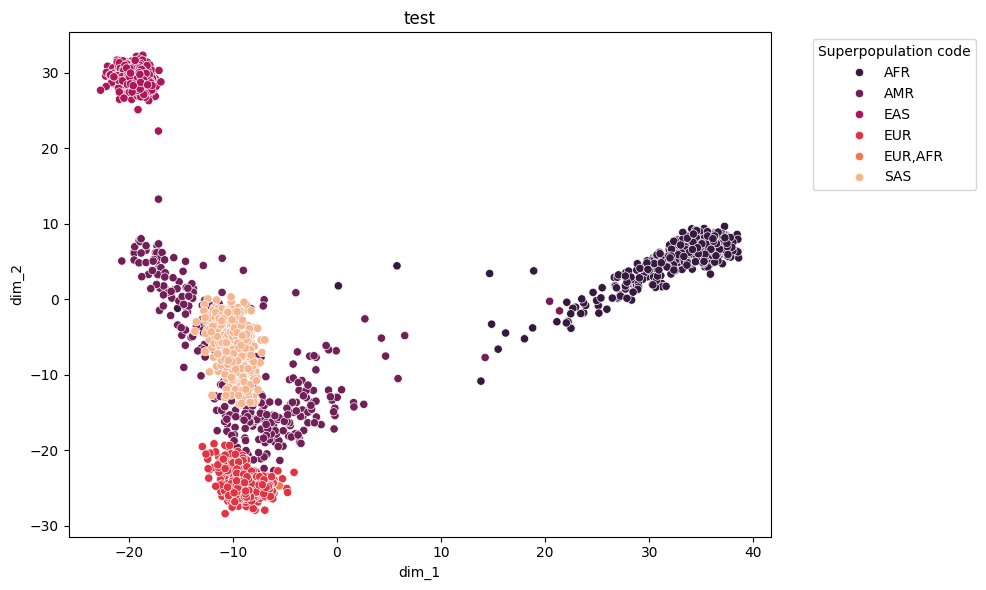

In [5]:
make_population_plot(merged_df, 'dim_1', 'dim_2', 'Superpopulation code', 'test', palette = 'rocket')

In [6]:
labels = silhouette_score_clusters(merged_df, ['dim_1', 'dim_2', 'dim_3'], plot=False)

/home/mat2m10/.pyenv/versions/3.8.12/envs/pca_projection/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/mat2m10/.pyenv/versions/3.8.12/envs/pca_projection/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/mat2m10/.pyenv/versions/3.8.12/envs/pca_projection/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/mat2m10/.pyenv/versions/3.8.12/envs/pca_pro

The optimal number of clusters is: 5


/home/mat2m10/.pyenv/versions/3.8.12/envs/pca_projection/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [7]:
merged_df['clusters'] = labels

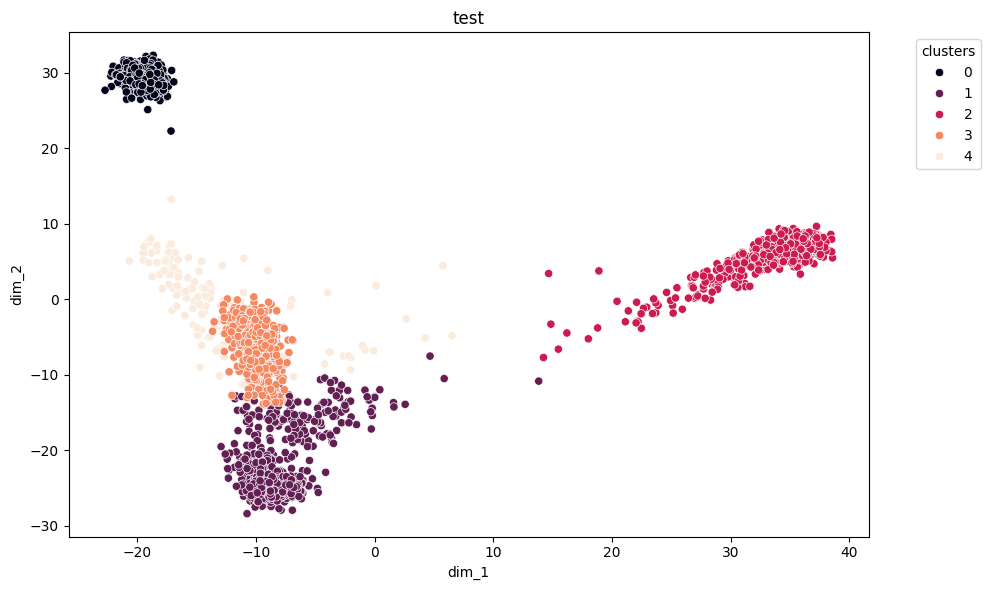

In [12]:
make_population_plot(merged_df, 'dim_1', 'dim_2', 'clusters', 'test', palette = 'rocket')

In [ ]:
merged_df

,FID,IID,PAT,MAT,SEX,PHENOTYPE,Sample name,Sex,Population code,Population name,Superpopulation code,Superpopulation name,dim_1,dim_2,dim_3,clusters
0,AFR,HG01879,0,0,1,-9,HG01879,male,ACB,African Caribbean,AFR,African Ancestry,27.057677,3.104165,-0.865002,2
1,AFR,HG01880,0,0,2,-9,HG01880,female,ACB,African Caribbean,AFR,African Ancestry,14.666324,3.394937,-7.951574,2
2,AFR,HG01882,0,0,1,-9,HG01882,male,ACB,African Caribbean,AFR,African Ancestry,34.530174,6.134562,-2.936865,2
3,AFR,HG01883,0,0,2,-9,HG01883,female,ACB,African Caribbean,AFR,African Ancestry,27.747052,3.531628,-1.601283,2
4,AFR,HG01885,0,0,1,-9,HG01885,male,ACB,African Caribbean,AFR,African Ancestry,32.931829,6.326269,-1.133794,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2499,SAS,NA21137,0,0,2,-9,NA21137,female,GIH,Gujarati,SAS,South Asian Ancestry,-10.061430,-8.314147,-20.789950,3
2500,SAS,NA21141,0,0,2,-9,NA21141,female,GIH,Gujarati,SAS,South Asian Ancestry,-10.743964,-7.951088,-17.523235,3
2501,SAS,NA21142,0,0,2,-9,NA21142,female,GIH,Gujarati,SAS,South Asian Ancestry,-9.204676,-6.124962,-18.066291,3
2502,SAS,NA21143,0,0,2,-9,NA21143,female,GIH,Gujarati,SAS,South Asian Ancestry,-10.427279,-8.130304,-18.962307,3


In [ ]:
path_input = f"{CONFIG['PATH_data']}/04_projected/"
path_output = f"{CONFIG['PATH_data']}/05_macro_per_pop/"
dims = [f for f in os.listdir(path_input) if f.startswith("dim")]
for dim in dims:
    path_dim = f"{path_input}/{dim}"
    chroms = [f for f in os.listdir(path_dim) if f.startswith("chrom")]
    for chrom in chroms:
        path_chrom = f"{path_dim}/{chrom}"
        for chunk in os.listdir(path_chrom):
            path_chunk = f"{path_chrom}/{chunk}"
            chunk_df = pd.read_pickle(path_chunk)
            chunk_df['clusters'] = labels
            for pop in chunk_df['clusters'].unique():
                pop_df = chunk_df[chunk_df['clusters'] == pop]
                pop_df = pop_df.drop(columns=['clusters'])
                os.makedirs(f"{path_output}/{dim}/pop_{pop}/{chrom}/", exist_ok=True)
                pop_df.to_pickle(f"{path_output}/{dim}/pop_{pop}/{chrom}/{chunk}")
            
    	

In [2]:
nr_of_projected_dimensions = 3

path_input = f"{CONFIG['PATH_data']}/05_macro_per_pop/"
path_output = f"{CONFIG['PATH_data']}/06_projected_per_pop/"
for dim in os.listdir(path_input):
    path_dim = f"{path_input}/{dim}"
    path_output_dim = f"{path_output}/{dim}"
    for pop in os.listdir(path_dim):
        path_pop = f"{path_dim}/{pop}"
        path_output_pop = f"{path_output_dim}/{pop}"
        project_on_dimensions(path_pop, path_output_pop, nr_of_projected_dimensions)
        

/tmp/ipykernel_25599/1815285419.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_humans[pop_dim] = PC_dim['PC1']
/tmp/ipykernel_25599/1815285419.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_humans[pop_dim] = PC_dim['PC1']
/tmp/ipykernel_25599/1815285419.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

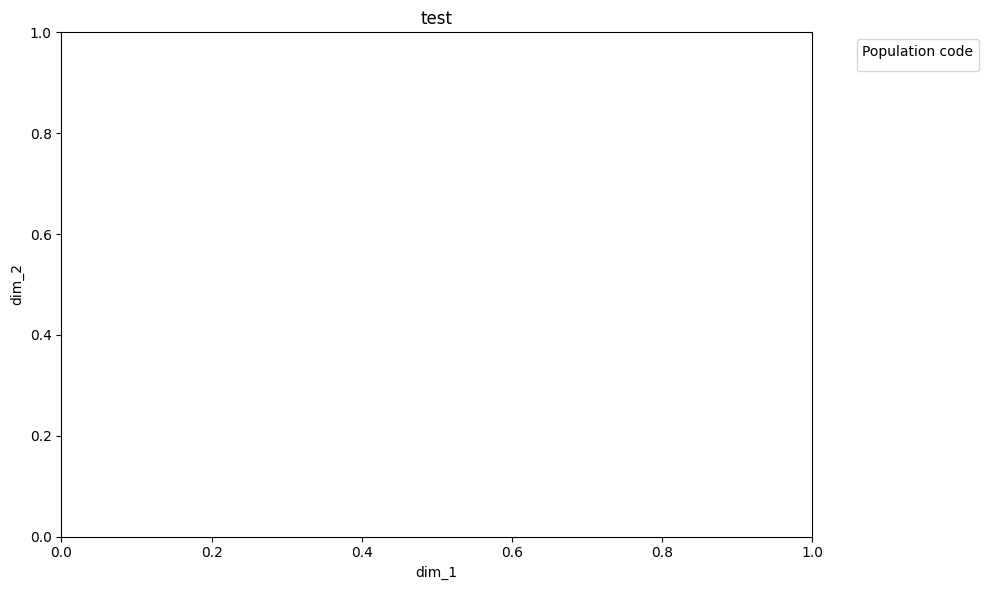

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


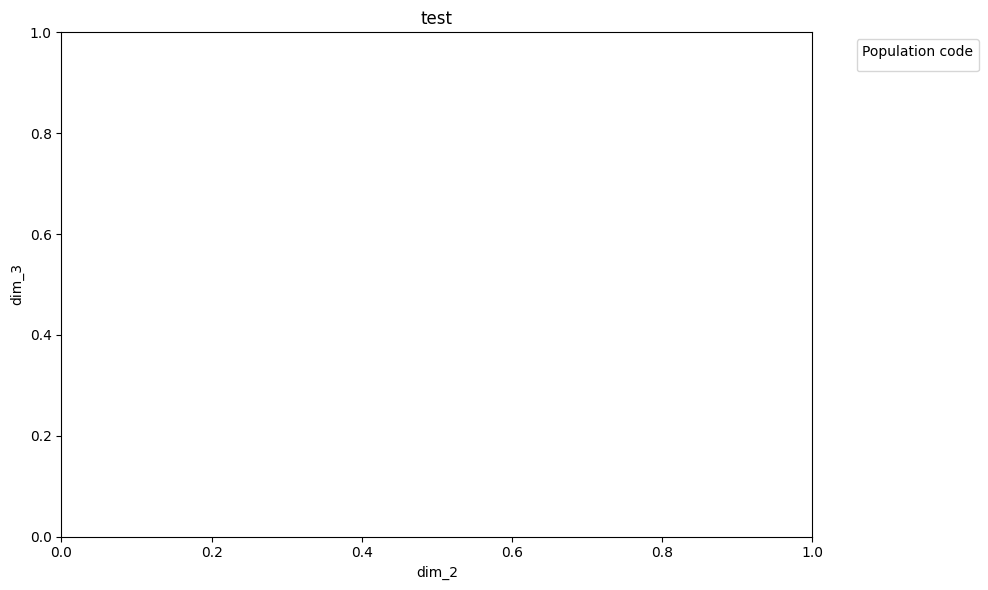

/tmp/ipykernel_25599/1815285419.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_humans[pop_dim] = PC_dim['PC1']


FileNotFoundError: [Errno 2] No such file or directory: '/mnt/e/GTM_data2/06_projected_per_pop//dim_1/pop_4/dim_2/global_PCs.pkl'

In [10]:

path_input = f"{CONFIG['PATH_data']}/06_projected_per_pop/"
for dim in os.listdir(path_input):
    path_dim = f"{path_input}/{dim}"
    for pop in os.listdir(path_dim):
        temp_humans = merged_df[merged_df['clusters'] == int(pop.split('_')[1])]	
        path_pop = f"{path_dim}/{pop}"
        for pop_dim in [f for f in os.listdir(path_pop) if f.startswith("dim")]:
            path_PCs = f"{path_pop}/{pop_dim}/global_PCs.pkl"
            PC_dim = pd.read_pickle(path_PCs)
            temp_humans[pop_dim] = PC_dim['PC1']
        make_population_plot(temp_humans, 'dim_1', 'dim_2', 'Population code', 'test', palette = 'rocket')
        make_population_plot(temp_humans, 'dim_2', 'dim_3', 'Population code', 'test', palette = 'rocket')
        

In [11]:
"""
N_PCs = 2
N_snps_block = 100

path_input = f"{CONFIG['PATH_data']}/04_projected/"
path_output = f"{CONFIG['PATH_data']}/05_ld_blocks/"

for dim in os.listdir(path_input):
    path_dim = f"{path_input}/{dim}"
    for chrom in [f for f in os.listdir(path_dim) if f.startswith("chrom")]:
        path_input_chrom = f"{path_dim}/{chrom}/"
        path_output_chrom = f"{path_output}/{dim}/{chrom}/"
        os.makedirs(path_output_chrom, exist_ok=True)
        for file in os.listdir(path_input_chrom):
            filename = file.split(".pkl")[0]
            segmenter(path_input_chrom, path_output_chrom, filename , N_PCs, N_snps_block)
"""

'\nN_PCs = 2\nN_snps_block = 100\n\npath_input = f"{CONFIG[\'PATH_data\']}/04_projected/"\npath_output = f"{CONFIG[\'PATH_data\']}/05_ld_blocks/"\n\nfor dim in os.listdir(path_input):\n    path_dim = f"{path_input}/{dim}"\n    for chrom in [f for f in os.listdir(path_dim) if f.startswith("chrom")]:\n        path_input_chrom = f"{path_dim}/{chrom}/"\n        path_output_chrom = f"{path_output}/{dim}/{chrom}/"\n        os.makedirs(path_output_chrom, exist_ok=True)\n        for file in os.listdir(path_input_chrom):\n            filename = file.split(".pkl")[0]\n            segmenter(path_input_chrom, path_output_chrom, filename , N_PCs, N_snps_block)\n'

In [39]:

"""
path_input = f"{CONFIG['PATH_data']}/05_LD_blocks/"
path_output = f"{CONFIG['PATH_data']}/06_esti_mafs/"
n_components = 4

for dim in os.listdir(path_input):
    path_dim = f"{path_input}/{dim}"
    for chrom in [f for f in os.listdir(path_dim) if f.startswith("chrom")]:
        path_input_chrom = f"{path_dim}/{chrom}/"
        path_output_chrom = f"{path_output}/{dim}/{chrom}/"
        blocks = [f for f in os.listdir(path_input_chrom) if f.startswith("block")]
        for block in blocks:
            linear_abyss(path_input_chrom, block, path_output_chrom, n_components, p2=True, twopq=True, q2=True)
"""

In [40]:
"""
# Align all the dataframes
path_input = f"{CONFIG['PATH_data']}/06_esti_mafs/"
dims = [f for f in os.listdir(path_input) if f.startswith("dim")]
for dim in dims:
    path_dim = f"{path_input}/{dim}"
    for chrom in [f for f in os.listdir(path_dim) if f.startswith("chrom")]:
        path_input_chrom = f"{path_dim}/{chrom}"
        blocks = [f for f in os.listdir(f"{path_input_chrom}/q2") if f.startswith("block")]
        for block in blocks:
            path_q2 = f"{path_input_chrom}/q2/{block}"
            path_2pq = f"{path_input_chrom}/2pq/{block}"
            path_p2 = f"{path_input_chrom}/p2/{block}"
            minaf = pd.read_pickle(path_q2)
            hetaf = pd.read_pickle(path_2pq)
            majaf = pd.read_pickle(path_p2)
            # Example usage with your loaded DataFrames
            minaf, hetaf, majaf = align_dataframes(minaf, hetaf, majaf)
            minaf.to_pickle(f"{path_input_chrom}/q2/{block}")
            hetaf.to_pickle(f"{path_input_chrom}/2pq/{block}")
            majaf.to_pickle(f"{path_input_chrom}/p2/{block}")
"""


In [ ]:
"""
path_input = f"{CONFIG['PATH_data']}/06_esti_mafs/"
path_output = f"{CONFIG['PATH_data']}/07_esti_Fst/"

dims = [f for f in os.listdir(path_input) if f.startswith("dim")]
for dim in dims:
    path_dim = f"{path_input}/{dim}"
    path_output_dim = f"{path_output}/{dim}"
    chroms = [f for f in os.listdir(path_dim) if f.startswith("chrom")]
    for chrom in chroms:
        path_input_chrom = f"{path_dim}/{chrom}/"
        path_output_chrom = f"{path_output_dim}/{chrom}/"
        os.makedirs(path_output_chrom, exist_ok=True)
        files = [f for f in os.listdir(f"{path_input_chrom}/p2/") if f.startswith("block")]
        for file in files:
            make_fst(path_input_chrom, file, path_output_chrom)
"""

In [2]:


path_input = f"{CONFIG['PATH_data']}/07_esti_Fst/"
dims = [f for f in os.listdir(path_input) if f.startswith("dim")]
for dim in dims:
    path_dim = f"{path_input}/{dim}"
    os.makedirs(path_dim, exist_ok=True)
    make_global_fst(path_dim, path_dim)


In [10]:
path_afs = f"{CONFIG['PATH_data']}/usefull/allele_frequencies.pkl"
path_ids = f"{CONFIG['PATH_data']}/usefull/ids.pkl"
path_panel = f"{CONFIG['PATH_data']}/usefull/all.panel"
ids = pd.read_pickle(path_ids)
labels = pd.read_pickle(path_panel)
merged_df = ids.merge(labels, left_on="IID", right_on="Sample name")

path_input = f"{CONFIG['PATH_data']}/07_esti_Fst/"
dims = [f for f in os.listdir(path_input) if f.startswith("dim")]
for dim in dims:
    path_dim = f"{path_input}/{dim}"
    Fst_global = pd.read_pickle(f"{path_dim}/global_Fst.pkl")
    
    reducer = umap.UMAP(n_components=1, metric='precomputed', random_state=42)
    embedding = reducer.fit_transform(Fst_global)
    merged_df[[f"{dim}"]] = embedding

/home/mat2m10/.pyenv/versions/3.8.12/envs/pca_projection/lib/python3.8/site-packages/umap/umap_.py:1865: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")
/home/mat2m10/.pyenv/versions/3.8.12/envs/pca_projection/lib/python3.8/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/home/mat2m10/.pyenv/versions/3.8.12/envs/pca_projection/lib/python3.8/site-packages/umap/umap_.py:1865: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")
/home/mat2m10/.pyenv/versions/3.8.12/envs/pca_projection/lib/python3.8/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/home/mat2m10/.pyenv/versions/3.8.12/envs/pca_projection/lib/pytho

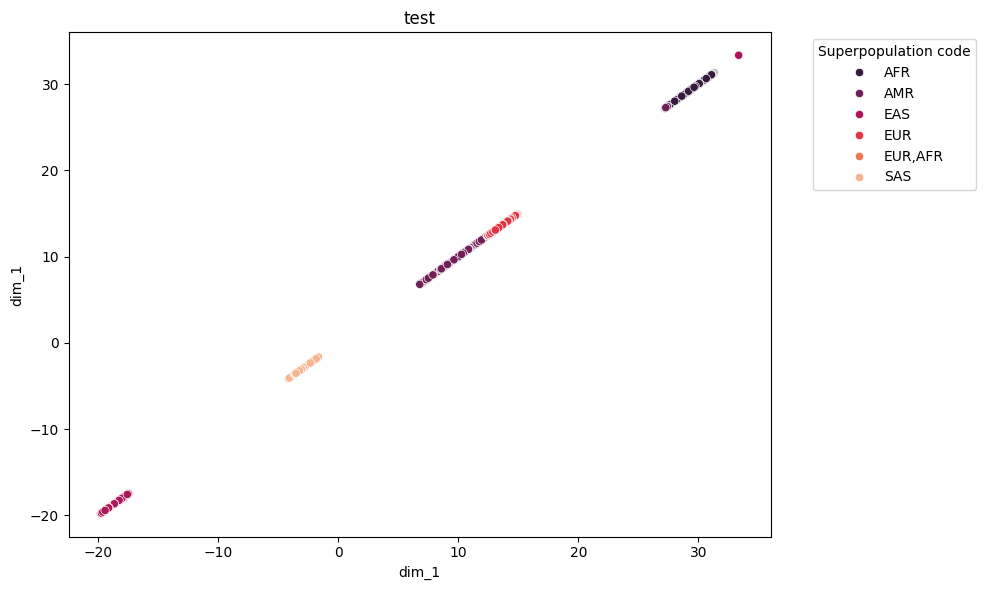

In [11]:
make_population_plot(merged_df, 'dim_1', 'dim_1', 'Superpopulation code', 'test', palette = 'rocket')


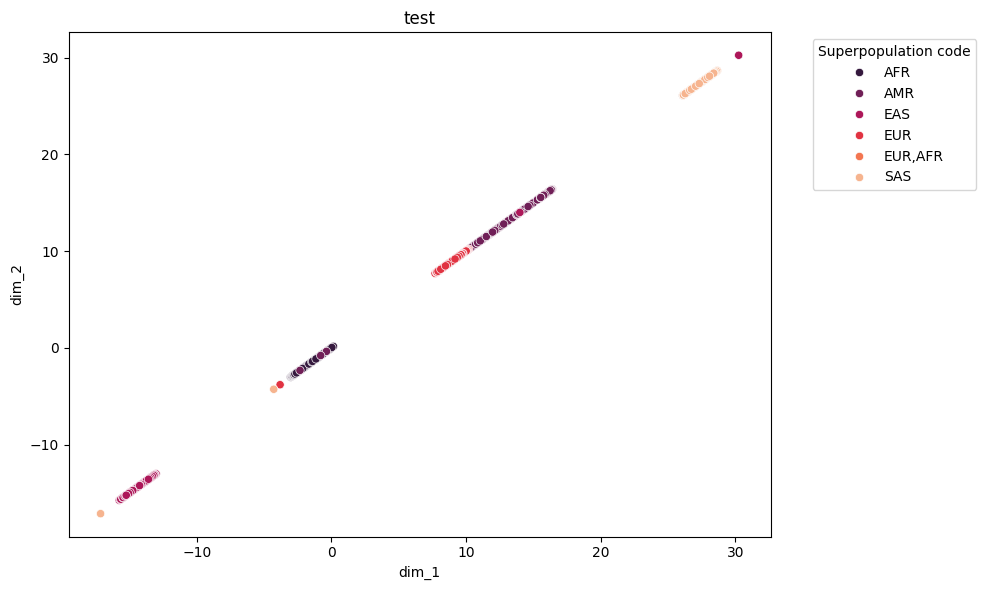

In [6]:
from sklearn.manifold import TSNE

path_afs = f"{CONFIG['PATH_data']}/usefull/allele_frequencies.pkl"
path_ids = f"{CONFIG['PATH_data']}/usefull/ids.pkl"
path_panel = f"{CONFIG['PATH_data']}/usefull/all.panel"
ids = pd.read_pickle(path_ids)
labels = pd.read_pickle(path_panel)
merged_df = ids.merge(labels, left_on="IID", right_on="Sample name")

path_input = f"{CONFIG['PATH_data']}/07_esti_Fst/"
dims = [f for f in os.listdir(path_input) if f.startswith("dim")]
for dim in dims:
    path_dim = f"{path_input}/{dim}"
    Fst_global = pd.read_pickle(f"{path_dim}/global_Fst.pkl")
    # Compute 1D t-SNE embedding with the correct init parameter
    tsne = TSNE(n_components=1, metric='precomputed', init='random', random_state=42)
    embeddings = tsne.fit_transform(Fst_global)
    merged_df[[f"{dim}"]] = embedding

make_population_plot(merged_df, 'dim_1', 'dim_2', 'Superpopulation code', 'test', palette = 'rocket')


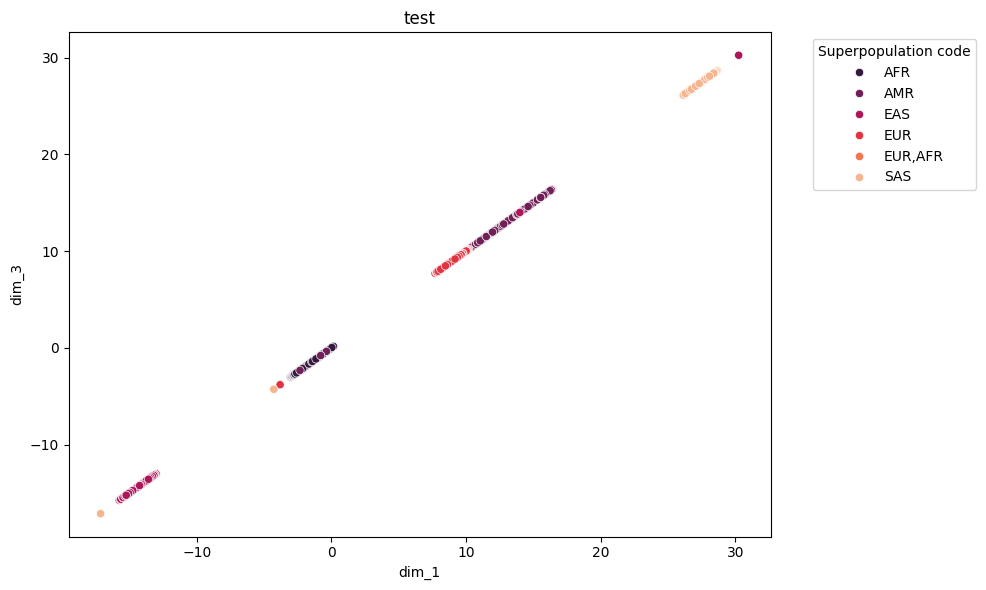

In [8]:
make_population_plot(merged_df, 'dim_1', 'dim_3', 'Superpopulation code', 'test', palette = 'rocket')
